# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import DistanceMetric
from math import radians

# Load Data

### Data Source:
https://www.kaggle.com/datasets/yasserh/uber-fares-dataset

In [4]:
fare_data = pd.read_csv('C:/Users/muham/Downloads/Personal Development/Projects/Group Projects/Uber Fares/uber.csv')

Problem Statement:

The project is about on world's largest taxi company Uber inc. In this project, we're looking to predict the fare for their future transactional cases. Uber delivers service to lakhs of customers daily. Now it becomes really important to manage their data properly to come up with new business ideas to get best results. Eventually, it becomes really important to estimate the fare prices accurately.

In [5]:
fare_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [6]:
fare_data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


Only two column with missing data, i.e, dropoff_longitude and dropoff_latitude

Mix of numerical and categorical variables:
- Numerical Variables:
    - pickup_datetime
    - pickup_latitude
    - pickup_longitude
    - dropoff_latitude
    - dropoff_longitude
- Categorical Variables:
    - passanger_count

Target variable is fare_amount

In [7]:
data = fare_data

In [8]:
data.nunique()

Unnamed: 0           200000
key                  200000
fare_amount            1244
pickup_datetime      196629
pickup_longitude      71066
pickup_latitude       83835
dropoff_longitude     76894
dropoff_latitude      90585
passenger_count           8
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


dropoff_longitude and dropoff_latitude have one missing row. We need to exclude this

In [10]:
data.nunique()

Unnamed: 0           200000
key                  200000
fare_amount            1244
pickup_datetime      196629
pickup_longitude      71066
pickup_latitude       83835
dropoff_longitude     76894
dropoff_latitude      90585
passenger_count           8
dtype: int64

In [11]:
# Dropping the columns 'Unnamed: 0' and 'key' as well as NA rows

data = data.drop(['Unnamed: 0','key'],axis=1)
data.dropna(axis=0,inplace=True)

# Exploratory Data Analysis (EDA) and Data Pre-processing

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,199999.0,11.359892,9.901760,-52.000000,6.000000,8.500000,12.500000,499.000000
pickup_longitude,199999.0,-72.527631,11.437815,-1340.648410,-73.992065,-73.981823,-73.967154,57.418457
pickup_latitude,199999.0,39.935881,7.720558,-74.015515,40.734796,40.752592,40.767158,1644.421482
dropoff_longitude,199999.0,-72.525292,13.117408,-3356.666300,-73.991407,-73.980093,-73.963658,1153.572603
dropoff_latitude,199999.0,39.923890,6.794829,-881.985513,40.733823,40.753042,40.768001,872.697628
passenger_count,199999.0,1.684543,1.385995,0.000000,1.000000,1.000000,2.000000,208.000000


Possibility of some outliers in fare amount and passanger

Outliers:
- Fare Amount is between -52 to 499. The negative amount seems unrealistic. Base fare to be set at $2.5
- Passanger count max is 208, which is also not possible. Max to be set at 5

### Identifying Correlations

In [13]:
# Identify Correlation
data.corr()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
fare_amount,1.000000,0.010458,-0.008482,0.008986,-0.011014,0.010158
pickup_longitude,0.010458,1.000000,-0.816461,0.833026,-0.846324,-0.000415
pickup_latitude,-0.008482,-0.816461,1.000000,-0.774787,0.702367,-0.001559
dropoff_longitude,0.008986,0.833026,-0.774787,1.000000,-0.917010,0.000033
dropoff_latitude,-0.011014,-0.846324,0.702367,-0.917010,1.000000,-0.000659
passenger_count,0.010158,-0.000415,-0.001559,0.000033,-0.000659,1.000000


<AxesSubplot:>

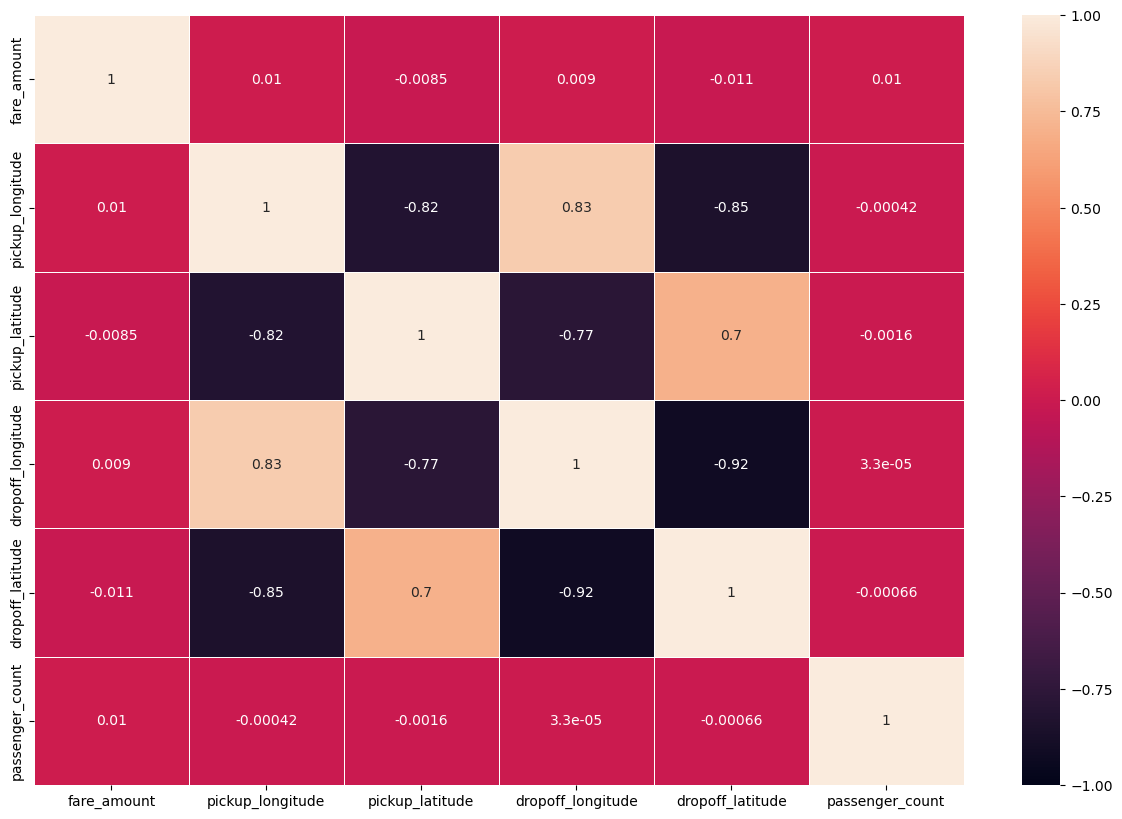

In [14]:
# Plot the Correlation matrix
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, linewidths=.5, vmin = -1, vmax = 1, fmt = '.2g')

High correlation can be observed between the geo-spatial data points, which was expected. Therefore, there is no need to drop any of the independent variables

In [15]:
from math import *

In [16]:
# Define formula to calculate haversine distance
def distance(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []
    
    for pos in range(len(longitude1)):
        long1,lati1,long2,lati2 = map(radians,[longitude1[pos],latitude1[pos],longitude2[pos],latitude2[pos]])
        dist_long = long2 - long1
        dist_lati = lati2 - lati1
        a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
        c = 2 * asin(sqrt(a))*6371
        travel_dist.append(c)
       
    return travel_dist

In [17]:
# Calculate Haversine distance for each row and add distance in km as a new column
data['distance_travelled'] = distance(data['pickup_longitude'].to_numpy(),
                                                data['pickup_latitude'].to_numpy(),
                                                data['dropoff_longitude'].to_numpy(),
                                                data['dropoff_latitude'].to_numpy()
                                              )

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fare_amount         199999 non-null  float64
 1   pickup_datetime     199999 non-null  object 
 2   pickup_longitude    199999 non-null  float64
 3   pickup_latitude     199999 non-null  float64
 4   dropoff_longitude   199999 non-null  float64
 5   dropoff_latitude    199999 non-null  float64
 6   passenger_count     199999 non-null  int64  
 7   distance_travelled  199999 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 13.7+ MB


In [19]:
# As we can see, pickup_datetime is being read as an object data type. However, we need to convert it into datetime data type
data['pickup_datetime']  = pd.to_datetime(data['pickup_datetime'])

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   fare_amount         199999 non-null  float64            
 1   pickup_datetime     199999 non-null  datetime64[ns, UTC]
 2   pickup_longitude    199999 non-null  float64            
 3   pickup_latitude     199999 non-null  float64            
 4   dropoff_longitude   199999 non-null  float64            
 5   dropoff_latitude    199999 non-null  float64            
 6   passenger_count     199999 non-null  int64              
 7   distance_travelled  199999 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 13.7 MB


In [21]:
# From pickup_datetime extract date, month, year, weekday and dayname
from datetime import datetime

data['date'] = pd.to_datetime(data['pickup_datetime']).dt.date
data['month'] = pd.to_datetime(data['pickup_datetime']).dt.month
data['year'] = pd.to_datetime(data['pickup_datetime']).dt.year
data['day_of_the_week'] = pd.to_datetime(data['pickup_datetime']).dt.weekday
data['day_name'] = pd.to_datetime(data['pickup_datetime']).dt.day_name()
data['pickup_time'] = pd.to_datetime(data['pickup_datetime']).dt.time
data['pickup_hour'] = pd.to_datetime(data['pickup_datetime']).dt.hour

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   fare_amount         199999 non-null  float64            
 1   pickup_datetime     199999 non-null  datetime64[ns, UTC]
 2   pickup_longitude    199999 non-null  float64            
 3   pickup_latitude     199999 non-null  float64            
 4   dropoff_longitude   199999 non-null  float64            
 5   dropoff_latitude    199999 non-null  float64            
 6   passenger_count     199999 non-null  int64              
 7   distance_travelled  199999 non-null  float64            
 8   date                199999 non-null  object             
 9   month               199999 non-null  int64              
 10  year                199999 non-null  int64              
 11  day_of_the_week     199999 non-null  int64              
 12  day_name        

### Outlier Treatment

The following treatment is being done to outliers:
- passanger_count should be less than 5
- rows with passanger_count = 0 should be dropped
- fare_amount should be kept to the minimum set by Uber, i.e., $2.5
- distance should be maximum 130 km
- distance travelled cannot be zero. Rows with distance = 0 must be dropped

In [23]:
data.drop(data[data['passenger_count'] > 5].index, axis=0, inplace = True)
data.drop(data[data['passenger_count'] == 0].index, axis=0, inplace = True)
data.drop(data[data['fare_amount'] < 2.5].index, axis=0, inplace = True)
data.drop(data[data['distance_travelled'] > 130].index, axis=0, inplace = True)
data.drop(data[data['distance_travelled'] == 0].index, axis=0, inplace = True)
data.dropna(axis=0,inplace=True)

In [24]:
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_travelled,date,month,year,day_of_the_week,day_name,pickup_time,pickup_hour
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,2015-05-07,5,2015,3,Thursday,19:52:06,19
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,2009-07-17,7,2009,4,Friday,20:04:56,20
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,2009-08-24,8,2009,0,Monday,21:45:00,21
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,2009-06-26,6,2009,4,Friday,08:22:21,8
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475450,2014-08-28,8,2014,3,Thursday,17:47:00,17


In [25]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,189061.0,11.336739,9.730745,2.500000,6.000000,8.500000,12.500000,499.000000
pickup_longitude,189061.0,-73.916225,2.560946,-75.419276,-73.992274,-73.982133,-73.968465,40.808425
pickup_latitude,189061.0,40.696089,2.634751,-74.015515,40.736440,40.753273,40.767532,401.066667
dropoff_longitude,189061.0,-73.915258,2.561027,-75.423067,-73.991594,-73.980564,-73.965513,40.831932
dropoff_latitude,189061.0,40.694481,2.501323,-74.015750,40.735345,40.753738,40.768327,45.031598
passenger_count,189061.0,1.595115,1.150926,1.000000,1.000000,1.000000,2.000000,5.000000
distance_travelled,189061.0,3.377859,3.984585,0.000084,1.279954,2.181325,3.938054,129.610094
month,189061.0,6.282337,3.439349,1.000000,3.000000,6.000000,9.000000,12.000000
year,189061.0,2011.719302,1.862527,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000
day_of_the_week,189061.0,3.049095,1.946679,0.000000,1.000000,3.000000,5.000000,6.000000


In [26]:
# Dropping the columns 'pickup datetime' and 'pickup hour' as we have extracted relvant pieces of information
# from these columns and do not need these columns for our analysis now. Also, 'date' and 'day_name', month and yuear
# as well as pickup and dropoff coordinates are not required as we have the required data extracted from them

data = data.drop(['pickup_datetime','pickup_time', 'date', 'pickup_longitude', 'pickup_latitude',
                  'dropoff_longitude', 'dropoff_latitude', 'day_name'],axis=1)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189061 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fare_amount         189061 non-null  float64
 1   passenger_count     189061 non-null  int64  
 2   distance_travelled  189061 non-null  float64
 3   month               189061 non-null  int64  
 4   year                189061 non-null  int64  
 5   day_of_the_week     189061 non-null  int64  
 6   pickup_hour         189061 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 11.5 MB


# Numerical Features - Univariate Analysis

## Boxplot & Histogram

### Distance

<AxesSubplot:xlabel='distance_travelled'>

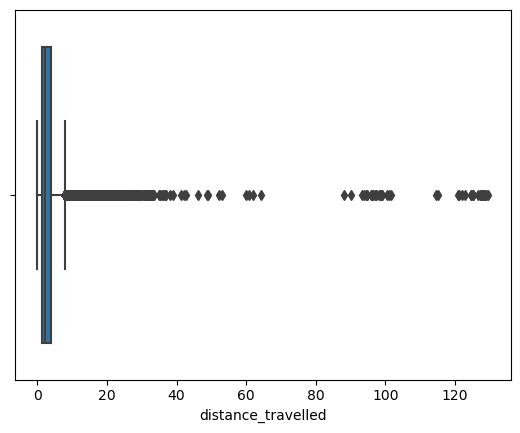

In [28]:
sns.boxplot(x=data['distance_travelled'])

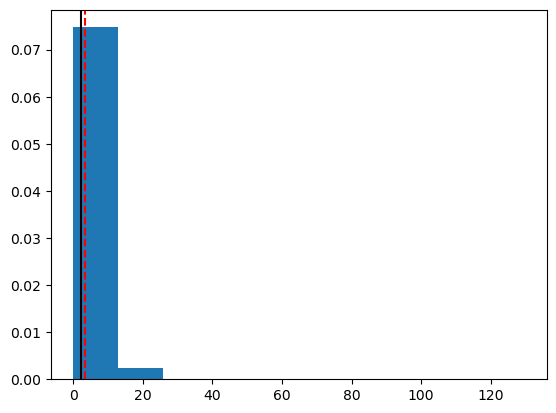

In [29]:
import matplotlib.pyplot as plt
hist = plt.hist(x=data['distance_travelled'], density = True)
# Draw a vertical line in the histogram to visualize mean value of the numerical feature (NaNs will be ignored when calculating the mean)
plt.axvline(data['distance_travelled'].mean(), color = 'red', linestyle='--')
# Draw another vertical line in the histogram to visualize median value of the numerical feature (NaNs will be ignored when calculating the median)
plt.axvline(data['distance_travelled'].median(), color = 'black', linestyle='-')

Observations:
- Negatively Skewed
- Outliers on the left end
- Mean and Median are close

# Categorical Features - Univariate Analysis

### Passenger Count

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '5'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

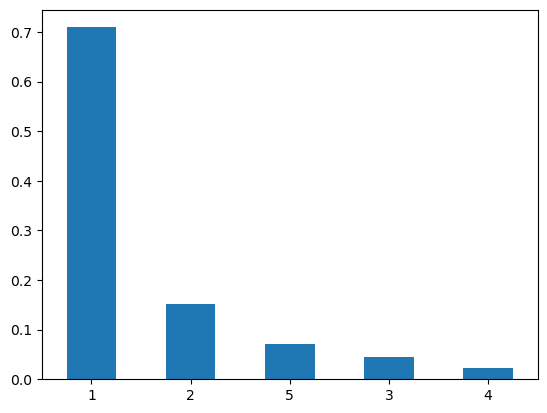

In [30]:
data['passenger_count'].value_counts(normalize = True).plot.bar()
plt.xticks(rotation = 0)

Observation:
- Almost 70% of trips had only 1 passanger

### Day of the week

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '4'),
  Text(1, 0, '5'),
  Text(2, 0, '3'),
  Text(3, 0, '2'),
  Text(4, 0, '1'),
  Text(5, 0, '6'),
  Text(6, 0, '0')])

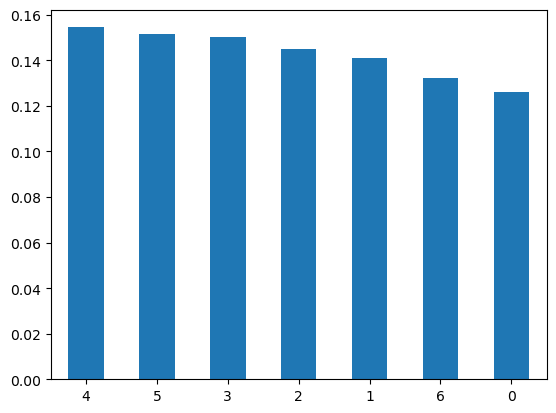

In [31]:
data['day_of_the_week'].value_counts(normalize = True).plot.bar()
plt.xticks(rotation = 0)

Observation:
- As expected, Friday (weekend eve) and Saturday had the highest number of trips

### Pickup Time

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, '19'),
  Text(1, 0, '18'),
  Text(2, 0, '20'),
  Text(3, 0, '21'),
  Text(4, 0, '22'),
  Text(5, 0, '13'),
  Text(6, 0, '12'),
  Text(7, 0, '23'),
  Text(8, 0, '14'),
  Text(9, 0, '17'),
  Text(10, 0, '15'),
  Text(11, 0, '11'),
  Text(12, 0, '9'),
  Text(13, 0, '8'),
  Text(14, 0, '10'),
  Text(15, 0, '16'),
  Text(16, 0, '0'),
  Text(17, 0, '7'),
  Text(18, 0, '1'),
  Text(19, 0, '2'),
  Text(20, 0, '6'),
  Text(21, 0, '3'),
  Text(22, 0, '4'),
  Text(23, 0, '5')])

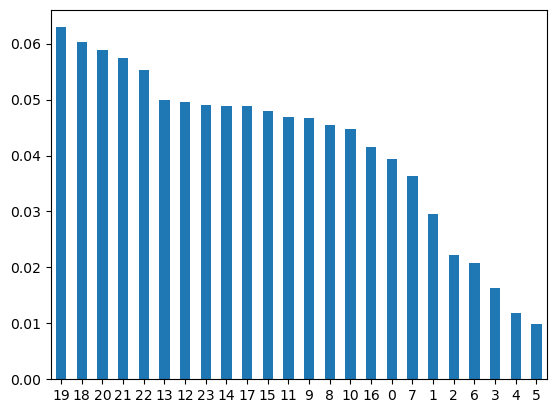

In [32]:
data['pickup_hour'].value_counts(normalize = True).plot.bar()
plt.xticks(rotation = 0)

Observation:
- AsThe number of trips are low during 1am - 5am, and peak between 7pm - 9pm

<AxesSubplot:title={'center':'Weekday Trips'}, xlabel='pickup_hour', ylabel='count'>

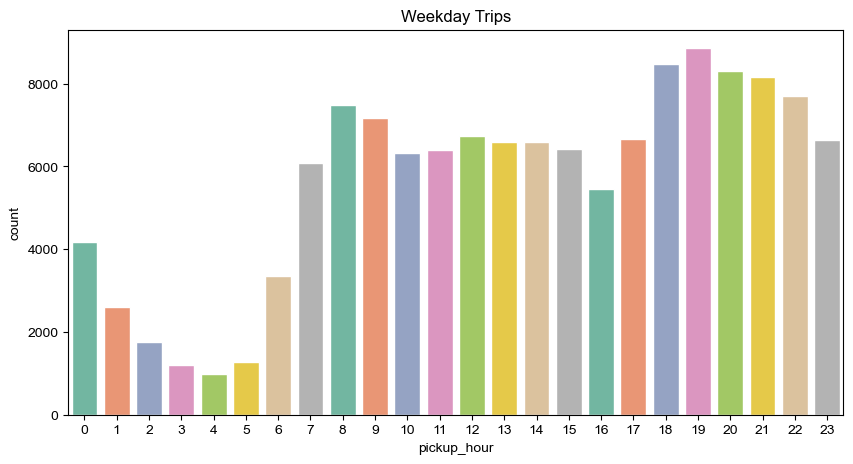

In [33]:
# Countplot in day of the week to see peak hours
plt.figure(figsize=(10,5))
plt.title('Weekday Trips')
sns.set_style("white")
#plot the countplot for weekdays
sns.countplot(x='pickup_hour', data=data.loc[(data.day_of_the_week >= 0) & (data.day_of_the_week <=4)], palette='Set2')

<AxesSubplot:title={'center':'Weekend Trips'}, xlabel='pickup_hour', ylabel='count'>

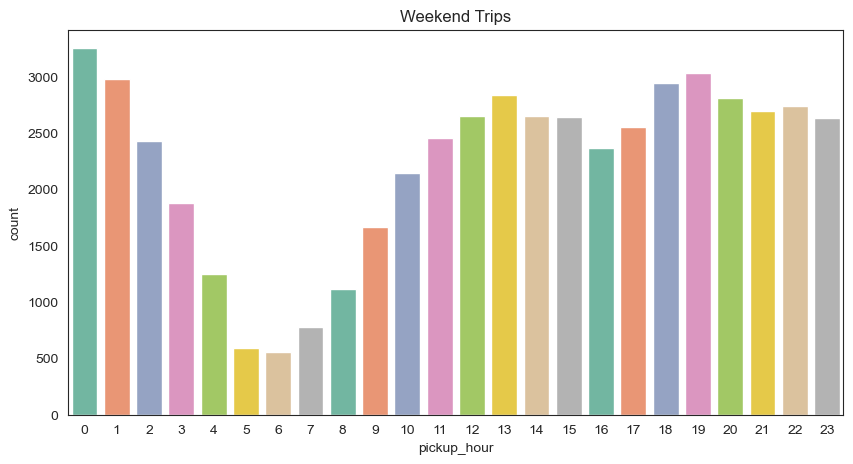

In [34]:
# Countplot in day of the week to see peak hours
plt.figure(figsize=(10,5))
plt.title('Weekend Trips')
sns.set_style("white")
#plot the countplot for weekdays
sns.countplot(x='pickup_hour', data=data.loc[(data.day_of_the_week >= 5) & (data.day_of_the_week <= 6)], palette='Set2')

We can clearly see that during weekdays, peak hours are during the day while on weekends, peak hours are late in the night

# Bivariate / Multivariate Analysis

In [35]:
import geopandas as gpd

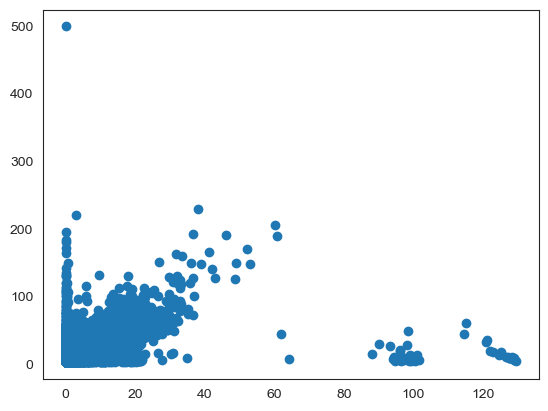

In [36]:
#Scatte plot of distance vs fare amount
plt.scatter(x = data.distance_travelled, y = data.fare_amount)

# Show the plot
plt.show()

Generally, as distance increases, the fare amount also increases with a few sporadic inconsistencies

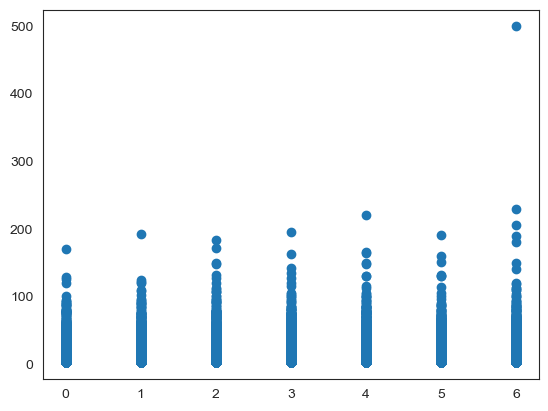

In [37]:
#Scatte plot of day of the week vs fare amount
plt.scatter(x = data.day_of_the_week, y = data.fare_amount)

# Show the plot
plt.show()

Generally speaking, weekend fares are higher than weekday fares. This could be due to distance travelled or due to peak hours

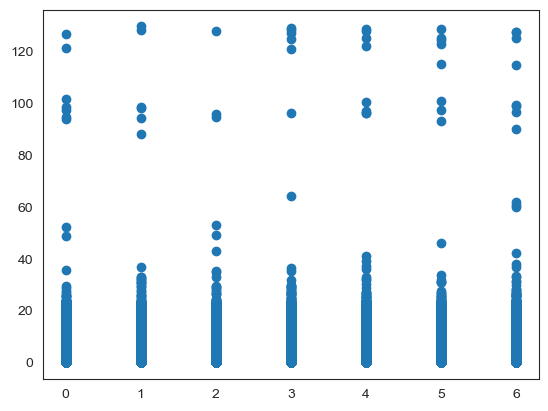

In [38]:
#Scatte plot of day of the week vs distance to see if there is any relationship between them
plt.scatter(x = data.day_of_the_week, y = data.distance_travelled)

# Show the plot
plt.show()

We see that there isn;t much of a relationship between distance travelled vs fay of the week - thus, it is appears that fare amount being higher on weekends has a high likelihood of being linked to peak hours / wait time due to higher traffic.

Unfortunately, we do not have the dropoff time for each ride to be able to ascertain the time of each trip and demonstrate if we can see a relationship between fare and time travelled

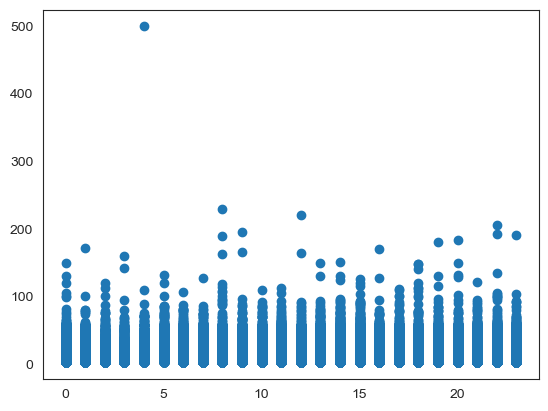

In [39]:
#Scatte plot of pickup time vs fare amount
plt.scatter(x = data.pickup_hour, y = data.fare_amount)

# Show the plot
plt.show()

We do see some pickup times having a greater % of higher fares as compared to others - however, it is difficult to draw a concluding relationship

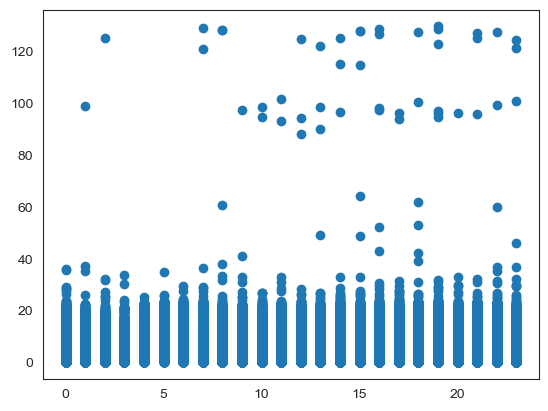

In [40]:
#Scatte plot of pickup time vs distance
plt.scatter(x = data.pickup_hour, y = data.distance_travelled)

# Show the plot
plt.show()

Some pickup hours have a greater concentration of trips where a high distance was travelled as compared to others

Linear
Logistic
RF Regressor
DT Regressor
SVR Regressor

### Data Preparatrion

In [41]:
# splitting data into training and test set using default parameters
x_train, x_test, y_train, y_test = train_test_split(data.drop('fare_amount', axis = 1), data['fare_amount'])

### Feature Scaling

Feature Scaling is required because of two reasons:
1. The data points are far from each other. This means that in some columns, the distance between data points is a lot
2. Some of the features have a unit while other features are unitless. Thereofre, it is important to make all features unitless

In [42]:
#Feature Scaling (Standardization)

from sklearn.preprocessing import StandardScaler

std = StandardScaler()

In [43]:
x = data.drop(['fare_amount'], axis = 1)
y = data['fare_amount'].values.reshape(-1, 1)

In [44]:
y_std = std.fit_transform(y)

x_std = std.fit_transform(x)

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y_std, test_size = 0.3, random_state = 42)

In [46]:
x_train.shape

(132342, 6)

In [47]:
y_train.shape

(132342, 1)

In [48]:
x_test.shape

(56719, 6)

In [49]:
y_test.shape

(56719, 1)

# Regression Models

In [50]:
# Linear Regression
# Random Forest Regressor
# Decision Tree Regressor
# SVR Regressor

## Linear Regression

In [51]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(x_train,y_train)

LinearRegression()

In [52]:
LR_pred = LR.predict(x_test)

In [53]:
print("Training set score: {:.2f}".format(LR.score(x_train, y_train)))
print("Test set score: {:.7f}".format(LR.score(x_test, y_test)))

Training set score: 0.65
Test set score: 0.5782372


In [54]:
from sklearn import metrics
from sklearn.metrics import r2_score

MAE_LR= metrics.mean_absolute_error(y_test, LR_pred)
MSE_LR= metrics.mean_squared_error(y_test, LR_pred)
RMSE_LR= np.sqrt(metrics.mean_squared_error(y_test, LR_pred))
r2_LR=r2_score(y_test, LR_pred)
Adj_r2_LR=1-(1-r2_score(y_test, LR_pred))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))

In [56]:
print('Mean absolute error of linear regression',MAE_LR)
print('Mean square  error of linear regression',MSE_LR)
print('root Mean square error of linear regression',RMSE_LR)
print('r2 score of linear regression',r2_LR)
print('adjusted r2 of linear regression',Adj_r2_LR)

Mean absolute error of linear regression 0.2573904473859175
Mean square  error of linear regression 0.4147342387915018
root Mean square error of linear regression 0.6439986326006459
r2 score of linear regression 0.5782372370795459
adjusted r2 of linear regression 0.5781926155430541


### Decision Tree Regressor

In [57]:
from sklearn.tree import DecisionTreeRegressor

DT = DecisionTreeRegressor()
DT.fit(x_train, y_train)

DecisionTreeRegressor()

In [58]:
DTpreds = DT.predict(x_test)

In [59]:
print("Training set score: {:.2f}".format(DT.score(x_train, y_train)))
print("Test set score: {:.7f}".format(DT.score(x_test, y_test)))

Training set score: 1.00
Test set score: 0.5534644


In [60]:
MAE_DT= metrics.mean_absolute_error(y_test, DTpreds)
MSE_DT= metrics.mean_squared_error(y_test, DTpreds)
RMSE_DT= np.sqrt(metrics.mean_squared_error(y_test, DTpreds))
r2_DT=r2_score(y_test, DTpreds)
Adj_r2_DT=1-(1-r2_score(y_test, DTpreds))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))

In [61]:
print('Mean absolute error of decision tree',MAE_DT)
print('Mean square  error of decision tree',MSE_DT)
print('root Mean square error of decision tree',RMSE_DT)
print('r2 score of decision tree',r2_DT)
print('adjusted r2 of decision tree',Adj_r2_DT)

Mean absolute error of decision tree 0.3057985965975342
Mean square  error of decision tree 0.4390942259940837
root Mean square error of decision tree 0.662641853488054
r2 score of decision tree 0.5534644198238359
adjusted r2 of decision tree 0.55341717737989


### Random Forest regressor

In [62]:
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor()
RF.fit(x_train, y_train)

C:\Users\muham\AppData\Local\Temp\ipykernel_35076\3802589840.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(x_train, y_train)


RandomForestRegressor()

In [63]:
RFpreds = RF.predict(x_test)

In [64]:
print("Training set score: {:.2f}".format(RF.score(x_train, y_train)))
print("Test set score: {:.7f}".format(RF.score(x_test, y_test)))

Training set score: 0.97
Test set score: 0.7909477


In [65]:
MAE_RF= metrics.mean_absolute_error(y_test, RFpreds)
MSE_RF= metrics.mean_squared_error(y_test, RFpreds)
RMSE_RF= np.sqrt(metrics.mean_squared_error(y_test, RFpreds))
r2_RF=r2_score(y_test, RFpreds)
Adj_r2_RF=1-(1-r2_score(y_test, RFpreds))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))

In [66]:
print('Mean absolute error of random forest',MAE_RF)
print('Mean square  error of random forest',MSE_RF)
print('root Mean square error of random forest',RMSE_RF)
print('r2 score of random forest',r2_RF)
print('adjusted r2 of random forest',Adj_r2_RF)

Mean absolute error of random forest 0.2250190611190339
Mean square  error of random forest 0.20556852672763393
root Mean square error of random forest 0.4533966549585847
r2 score of random forest 0.7909476920575127
adjusted r2 of random forest 0.7909255748010651


# Boosting

In [67]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

## Gradient Boosting

In [68]:
gbr = GradientBoostingRegressor(random_state = 42)
gbr.fit(x_train, y_train)
predictions_gbr = gbr.predict(x_test)

C:\Users\muham\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
print("Training set score: {:.2f}".format(gbr.score(x_train, y_train)))
print("Test set score: {:.7f}".format(gbr.score(x_test, y_test)))

Training set score: 0.82
Test set score: 0.7828862


In [70]:
MAE_GBR= metrics.mean_absolute_error(y_test, predictions_gbr)
MSE_GBR= metrics.mean_squared_error(y_test, predictions_gbr)
RMSE_GBR= np.sqrt(metrics.mean_squared_error(y_test, predictions_gbr))
r2_GBR=r2_score(y_test, predictions_gbr)
Adj_r2_GBR=1-(1-r2_score(y_test, predictions_gbr))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))

In [71]:
print('Mean absolute error of gradient boosting regressor',MAE_GBR)
print('Mean square  error of gradient boosting regressor',MSE_GBR)
print('root Mean square error of gradient boosting regressor',RMSE_GBR)
print('r2 score of gradient boosting regressor',r2_GBR)
print('adjusted r2 of gradient boosting regressor',Adj_r2_GBR)

Mean absolute error of gradient boosting regressor 0.2119350848285695
Mean square  error of gradient boosting regressor 0.2134956752780714
root Mean square error of gradient boosting regressor 0.46205592224109776
r2 score of gradient boosting regressor 0.7828862016812764
adjusted r2 of gradient boosting regressor 0.7828632315375694


## XGBoost Classifier

In [72]:
from xgboost import XGBRegressor

In [73]:
xgb = XGBRegressor(random_state = 42, scale_pos_weight = 1)
xgb.fit(x_train, y_train)
predictions_xgb = xgb.predict(x_test)

In [74]:
print("Training set score: {:.2f}".format(xgb.score(x_train, y_train)))
print("Test set score: {:.7f}".format(xgb.score(x_test, y_test)))

Training set score: 0.88
Test set score: 0.7880571


In [75]:
MAE_XGB= metrics.mean_absolute_error(y_test, predictions_xgb)
MSE_XGB= metrics.mean_squared_error(y_test, predictions_xgb)
RMSE_XGB= np.sqrt(metrics.mean_squared_error(y_test, predictions_xgb))
r2_XGB=r2_score(y_test, predictions_xgb)
Adj_r2_XGB=1-(1-r2_score(y_test, predictions_xgb))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))

In [76]:
print('Mean absolute error of XGB regressor',MAE_XGB)
print('Mean square  error of XGB regressor',MSE_XGB)
print('root Mean square error of XGB regressor',RMSE_XGB)
print('r2 score of XGB regressor',r2_XGB)
print('adjusted r2 of XGB regressor',Adj_r2_XGB)

Mean absolute error of XGB regressor 0.21013585337713858
Mean square  error of XGB regressor 0.20841097125744246
root Mean square error of XGB regressor 0.4565205047502713
r2 score of XGB regressor 0.7880570764627322
adjusted r2 of XGB regressor 0.7880346533857604


# Choosing the best models

In [78]:
cols = ['Model', 'MSE', 'RMSE', 'R2_score','MAE','ADJ_r']

# create a empty dataframe of the colums
result_table = pd.DataFrame(columns = cols)

In [79]:
full_metrics = pd.Series({'Model': "Linear Regression", 'MSE': MSE_LR, 'RMSE' : RMSE_LR, 'R2_score' : r2_LR,'MAE':MAE_LR,'ADJ_r':Adj_r2_LR})

In [80]:
result_table = result_table.append(full_metrics, ignore_index = True)

C:\Users\muham\AppData\Local\Temp\ipykernel_35076\917985854.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [81]:
full_metrics = pd.Series({'Model': "Decision Tree", 'MSE': MSE_DT, 'RMSE' : RMSE_DT, 'R2_score' : r2_DT,'MAE':MAE_DT,'ADJ_r':Adj_r2_DT})

In [82]:
result_table = result_table.append(full_metrics, ignore_index = True)

C:\Users\muham\AppData\Local\Temp\ipykernel_35076\917985854.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [84]:
full_metrics = pd.Series({'Model': "Random Forest", 'MSE': MSE_RF, 'RMSE' : RMSE_RF, 'R2_score' : r2_RF,'MAE':MAE_RF,'ADJ_r':Adj_r2_RF})

In [85]:
result_table = result_table.append(full_metrics, ignore_index = True)

C:\Users\muham\AppData\Local\Temp\ipykernel_35076\917985854.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [86]:
full_metrics = pd.Series({'Model': "Gardient Boosting", 'MSE': MSE_GBR, 'RMSE' : RMSE_GBR, 'R2_score' : r2_GBR,'MAE':MAE_GBR,'ADJ_r':Adj_r2_GBR})

In [87]:
result_table = result_table.append(full_metrics, ignore_index = True)

C:\Users\muham\AppData\Local\Temp\ipykernel_35076\917985854.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [88]:
full_metrics = pd.Series({'Model': "XGBoost", 'MSE': MSE_XGB, 'RMSE' : RMSE_XGB, 'R2_score' : r2_XGB,'MAE':MAE_XGB,'ADJ_r':Adj_r2_XGB})

In [89]:
result_table = result_table.append(full_metrics, ignore_index = True)

C:\Users\muham\AppData\Local\Temp\ipykernel_35076\917985854.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [90]:
result_table

,Model,MSE,RMSE,R2_score,MAE,ADJ_r
0,Linear Regression,0.414734,0.643999,0.578237,0.257390,0.578193
1,Decision Tree,0.439094,0.662642,0.553464,0.305799,0.553417
2,Random Forest,0.205569,0.453397,0.790948,0.225019,0.790926
3,Gardient Boosting,0.213496,0.462056,0.782886,0.211935,0.782863
4,XGBoost,0.208411,0.456521,0.788057,0.210136,0.788035


Based on the above, Random Forest produces the best results out of all tested models. However, hyperparameter tuning could help improve the results